# 并行化（Parallelization）
- 并行化（Parallelization）允许多个子任务同时执行，而不是顺序执行，从而显著减少整体执行时间。
- 并行化应用于多个组件，如大语言模型调用、工具使用或子代理调用，可以独立完成任务。
- 传统顺序工作流示例：先搜索Source A，后总结，再搜索Source B，继续总结，最后合成答案；而并行工作流示例是同时搜索和总结Source A和B，最后合成答案。
- 并行化核心思想是识别不依赖于其他步骤输出的任务部分，允许它们并发执行，尤其适合处理有延迟的外部服务请求。
- 实现并行化需用支持异步执行或多线程、多进程的框架，现代智能代理框架通常设计时已考虑异步操作，方便并行任务定义。
- 框架示例包括LangChain、LangGraph和Google ADK，它们通过不同机制支持并行执行：
  - LangChain表达式语言（LCEL）允许组合可运行对象，通过运算符“|”和图结构定义并发节点。
  - Google ADK提供工具管理并行执行，支持多代理系统的设计与实施。
- 并行化提升了智能代理系统处理多任务时的效率和响应速度，尤其是在涉及独立查询、计算和外部交互时，是优化复杂代理工作流的重要技术。

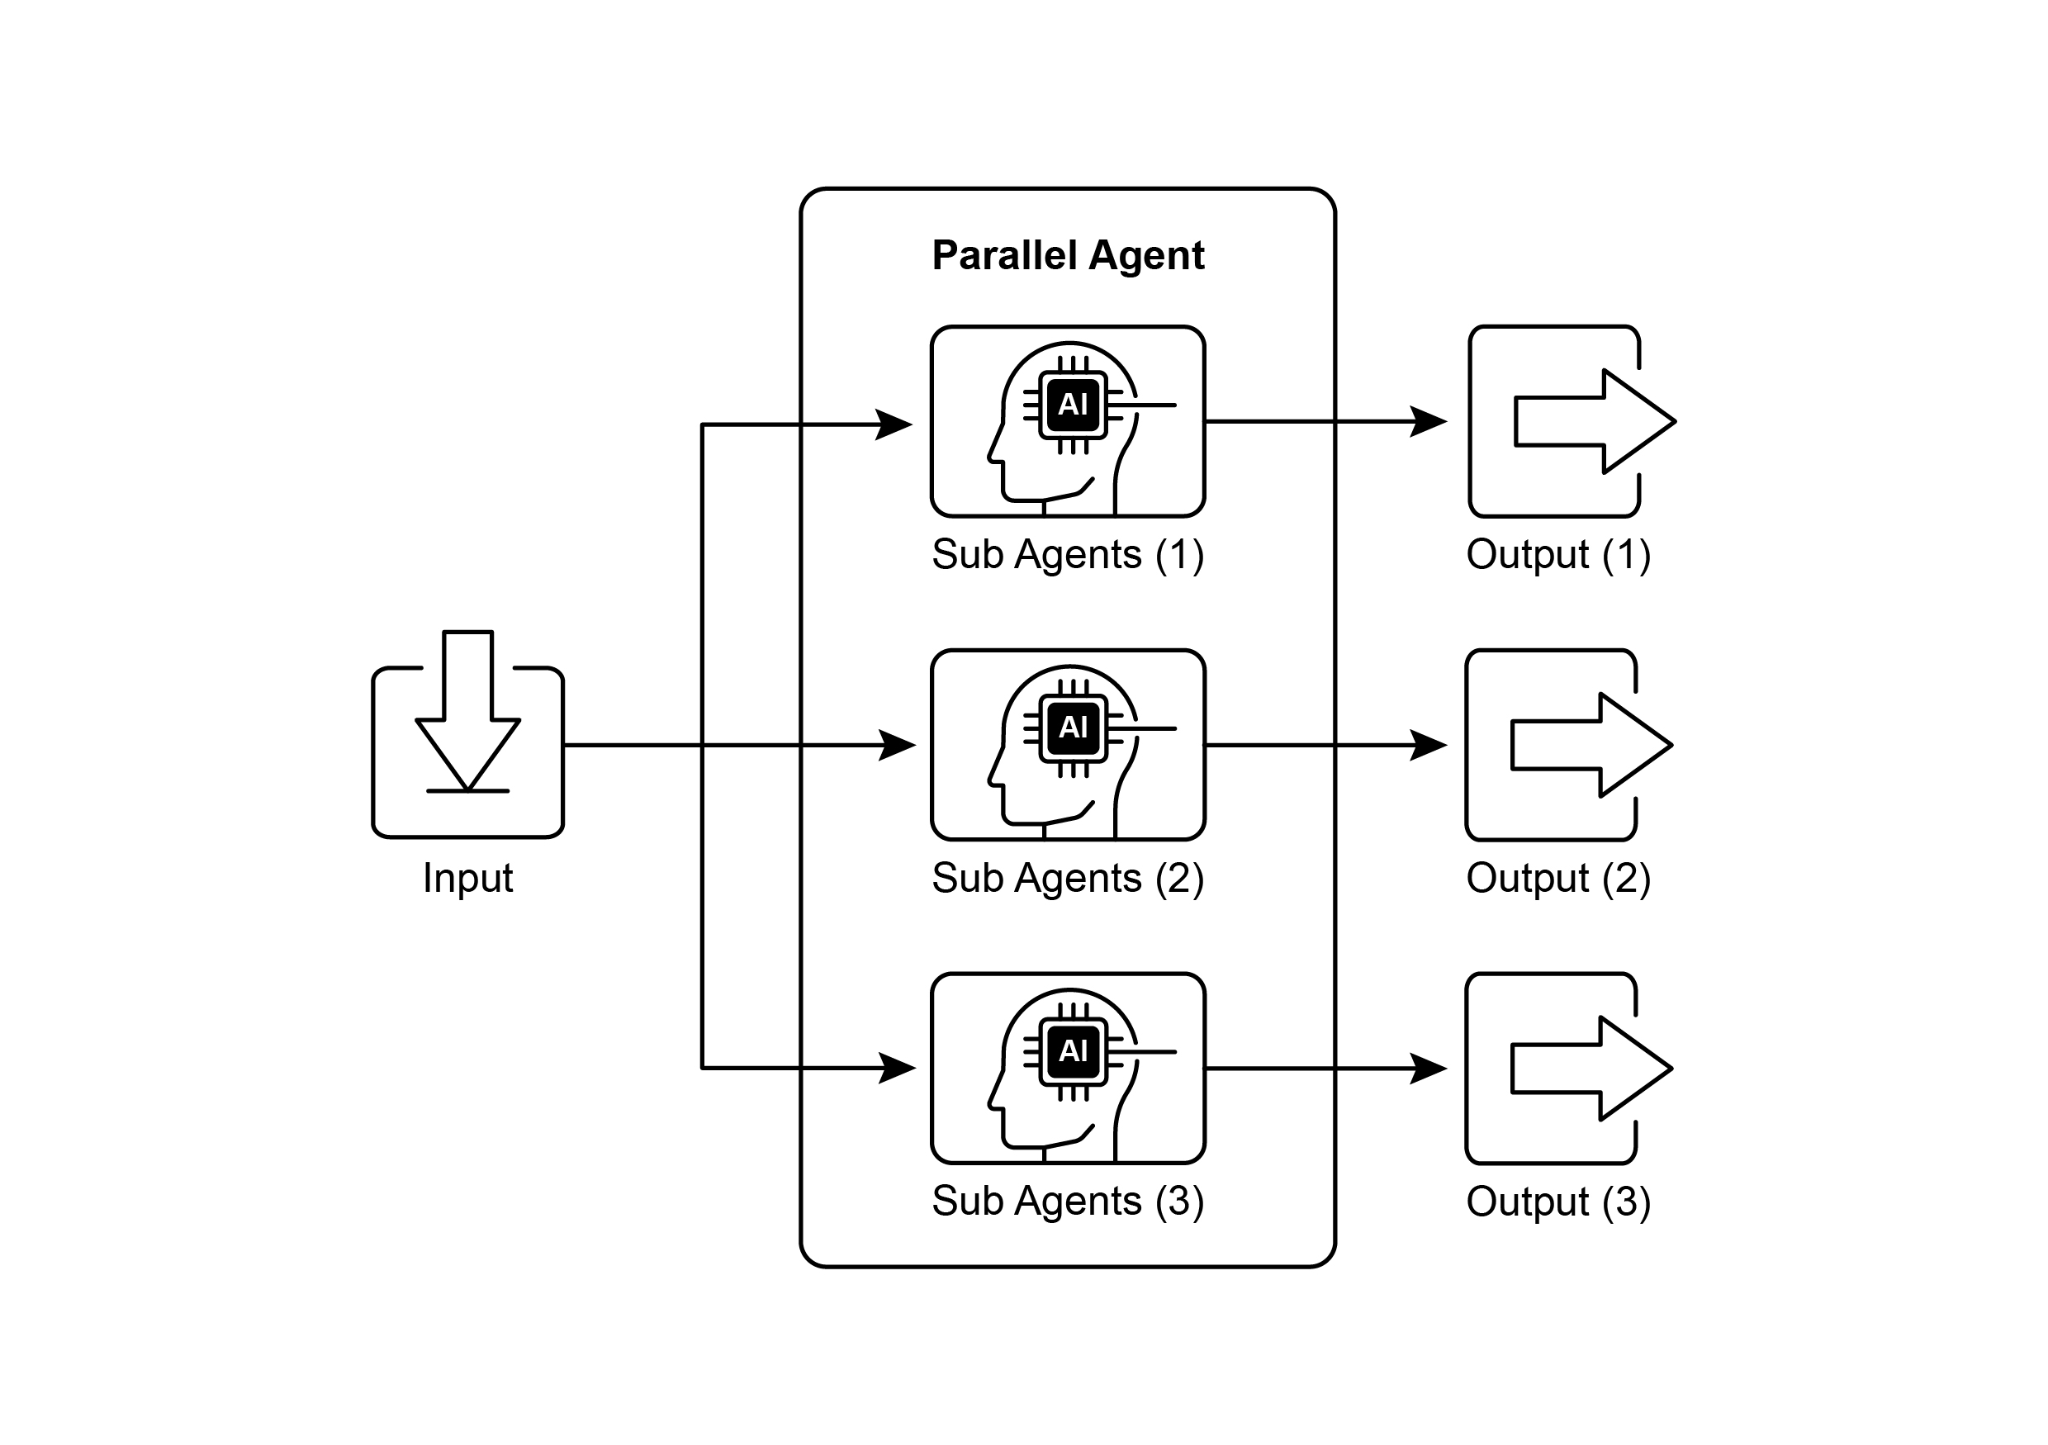


## 应用场景
- 信息收集与研究：
  - 同时从新闻、股票、社交媒体和数据库获取信息。
  - 优点：比顺序查询更快，获取全面视图。
- 数据处理与分析：
  - 并行进行情感分析、关键词提取、反馈分类及紧急问题识别。
  - 优点：提供多维度快速分析。
- 多API或工具交互：
  - 同时调用多个API获取信息或执行动作，如查询航班、酒店和本地活动。
  - 优点：加快旅行计划速度。
- 多组件内容生成：
  - 并行生成邮件标题、正文、相关图片和按钮文本。
  - 优点：更高效完成营销邮件制作。
- 验证与校验：
  - 同时验证邮件格式、电话号码、地址等多项输入。
  - 优点：更快反馈输入有效性。
- 多模态处理：
  - 同时处理文本和图像，进行情感、关键词及图像识别分析。
  - 优点：整合多模态信息，提升洞察力。
- A/B测试或多选项生成：
  - 并行生成多个文本选项，如不同标题，快速比较选择最佳。
- 并行化为代理设计的基础优化技术，提升应用的性能和响应速度。

## 实战示例

### 使用LangChain实现并行化
该Python代码实现了一个LangChain应用，旨在通过并行执行高效处理给定主题。
- 使用事件循环来切换任务，保证在单线程内进行多任务处理，避免Python的全局解释器锁(GIL)限制。
- 导入langchain_openai和langchain_core模块，包含语言模型、提示、输出解析器和可运行结构等重要组件。
- 创建了一个ChatOpenAI实例，设置了温度参数以控制生成的随机性，并使用try-except块处理模型初始化中的异常。
- 定义了三个独立的LangChain链，分别用于：概述摘要、生成主题相关问题列表和提取关键字。
- 每条链由ChatPromptTemplate定制，包括特定提示词、初始化语言模型和输出解析器，将输出格式化为字符串。
- 通过RunnableParallel将这三条链捆绑，可以同时执行，实现并行调用。
- RunnablePassThrough确保原始输入主题可供后续步骤使用。
- 创建了一个ChatPromptTemplate来定义最终汇总步骤的端到端提示，这一步结合了之前链的输出，生成领域总结。
- 通过异步函数run_parallel_example演示了如何执行并行调用，并使用asyncio.run管理异步执行。
- 整个代码流程设计实现了多次调用语言模型的协同工作，提升了处理多个LLM调用的效率，体现了并行化思维。

In [17]:
import os
import asyncio
import dotenv
from typing import Optional

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import Runnable, RunnableParallel, RunnablePassthrough
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Markdown
from pprint import pprint

In [3]:
from dotenv import load_dotenv
load_dotenv()


True

In [ ]:
try:
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
    pprint(f"Language model initialized: {llm.model}")
except Exception as e:
    pprint(f"Error initializing language model: {e}")
    llm = None

Language model initialized: gemini-2.5-flash


In [8]:
# --- 定义独立的链 ---
# 这三条链代表彼此独立、可同时执行的任务。
summarize_chain: Runnable = (
    ChatPromptTemplate.from_messages([
        ("system", "Summarize the following topic concisely:"),
        ("user", "{topic}")
    ])
    | llm
    | StrOutputParser()
)

questions_chain: Runnable = (
    ChatPromptTemplate.from_messages([
        ("system", "Generate three interesting questions about the following topic:"),
        ("user", "{topic}")
    ])
    | llm
    | StrOutputParser()
)

terms_chain: Runnable = (
    ChatPromptTemplate.from_messages([
        ("system", "Identify 5-10 key terms from the following topic, separated by commas:"),
        ("user", "{topic}")
    ])
    | llm
    | StrOutputParser()
)

In [9]:
# --- 定义要并行执行的任务块。这些结果以及原始内容将作为输入传递给下一步。
map_chain = RunnableParallel(
    {
        "summary": summarize_chain,
        "questions": questions_chain,
        "key_terms": terms_chain,
        "topic": RunnablePassthrough(),  # Pass the original topic through
    }
)


In [11]:
# --- 定义最终的综合提示，将并行结果合并。
synthesis_prompt = ChatPromptTemplate.from_messages([
    ("system", """Based on the following information:
     Summary: {summary}
     Related Questions: {questions}
     Key Terms: {key_terms}
     Synthesize a comprehensive answer."""),
    ("user", "Original topic: {topic}")
])

In [12]:
# --- 通过将并行结果直接传递给综合提示，然后是语言模型和输出解析器，构建完整的链。
full_parallel_chain = map_chain | synthesis_prompt | llm | StrOutputParser()

In [ ]:
# --- 运行链 ---
async def run_parallel_example(topic: str) -> None:
    """
    Asynchronously invokes the parallel processing chain with a specific topic
    and prints the synthesized result.

    Args:
        topic: The input topic to be processed by the LangChain chains.
    """
    if not llm:
        pprint("LLM not initialized. Cannot run example.")
        return

    pprint(f"\n--- Running Parallel LangChain Example for Topic: '{topic}' ---")
    try:
        # The input to `ainvoke` is the single 'topic' string, which is
        # then passed to each runnable in the `map_chain`.
        # `ainvoke` 的输入是单个 'topic' 字符串，该字符串随后会被传递给 `map_chain` 中的每个可运行项。
        response = await full_parallel_chain.ainvoke(topic)
        pprint("\n--- Final Response ---")
        pprint(response)
    except Exception as e:
        pprint(f"\nAn error occurred during chain execution: {e}")

In [18]:
test_topic = "The history of space exploration"
await run_parallel_example(test_topic)


--- Running Parallel LangChain Example for Topic: 'The history of space exploration' ---

--- Final Response ---
The history of space exploration is a remarkable journey of human ambition and technological advancement, originating in the **mid-20th century** as a direct consequence of the **Cold War Space Race** between the United States and the Soviet Union.

This early period was primarily a **geopolitical contest**, driven by national prestige, ideological supremacy, and military advantage. However, this intense competition undeniably **accelerated scientific and technological advancements** that might have taken decades longer under different circumstances. The rapid succession of milestones is testament to this: the Soviet Union launched **Sputnik 1**, the first artificial **satellite**, in 1957, marking the dawn of the space age. This was swiftly followed by **Yuri Gagarin's** historic flight in 1961, making him the first human in space. The United States responded with its ambi

### 使用Google ADK实现并行化
- 该代码定义了一个多智能体系统，用于研究和综合关于可持续技术进展的信息。
- 设置了三个LlmAgent实例作为专门的研究者：
  - ResearcherAgent_1：专注于可再生能源。
  - ResearcherAgent_2：研究电动汽车技术。
  - ResearcherAgent_3：调查碳捕获方法。
- 每个研究者智能体使用GEMINI_MODEL和google_search工具，简洁总结发现（1-2句）并存储于会话状态中的output_key。
- 创建了一个并行智能体ParallelWebResearchAgent，负责同时运行这三个研究者智能体，提升研究效率，完成后将结果存入状态。
- 定义了一个MergerAgent，负责综合研究者们存储的总结，严格基于输入总结生成包含各主题标题和总体结论的报告，禁止添加外部知识。
- 创建SequentialAgent名为ResearchAndSynthesisPipeline来协调整个工作流程：
  - 先执行ParallelAgent进行研究。
  - 再执行MergerAgent综合汇总。
- 将SequentialAgent设置为root_agent，作为运行该多智能体系统的入口点。
- 该设计实现了从多来源并行收集信息，到整合形成单一结构化报告的高效流程。

In [22]:
from google.adk.agents import LlmAgent, ParallelAgent, SequentialAgent
from google.adk.tools import google_search
GEMINI_MODEL = "gemini-2.5-flash"

In [26]:
researcher_agent_1 = LlmAgent(
    name="RenewableEnergyResearcher",
    model=GEMINI_MODEL,
    instruction="""You are an AI Research Assistant specializing in energy.
Research the latest advancements in 'renewable energy sources'.
Use the Google Search tool provided.
Summarize your key findings concisely (1-2 sentences).
Output *only* the summary.
""",
    description="Researches renewable energy sources.",
    tools=[google_search],
    # Store result in state for the merger agent
    output_key="renewable_energy_result"
)

# 研究员 2：电动汽车
researcher_agent_2 = LlmAgent(
    name="EVResearcher",
    model=GEMINI_MODEL,
    instruction="""You are an AI Research Assistant specializing in transportation.
Research the latest developments in 'electric vehicle technology'.
Use the Google Search tool provided.
Summarize your key findings concisely (1-2 sentences).
Output *only* the summary.
""",
    description="Researches electric vehicle technology.",
    tools=[google_search],
    # Store result in state for the merger agent
    output_key="ev_technology_result"
)

# 研究员 3：碳捕获
researcher_agent_3 = LlmAgent(
    name="CarbonCaptureResearcher",
    model=GEMINI_MODEL,
    instruction="""You are an AI Research Assistant specializing in climate solutions.
Research the current state of 'carbon capture methods'.
Use the Google Search tool provided.
Summarize your key findings concisely (1-2 sentences).
Output *only* the summary.
""",
    description="Researches carbon capture methods.",
    tools=[google_search],
    # Store result in state for the merger agent
    output_key="carbon_capture_result"
)


In [ ]:
# --- 2. 创建 ParallelAgent（并行运行多个研究员子智能体） ---
# 该智能体协调多个研究员子智能体的并发执行。
# 所有研究员完成工作并将结果写入状态后，流程即结束。
parallel_research_agent = ParallelAgent(
    name="ParallelWebResearchAgent",
    sub_agents=[researcher_agent_1, researcher_agent_2, researcher_agent_3],
    description="Runs multiple research agents in parallel to gather information."
)

In [28]:
merger_agent = LlmAgent(
    name="SynthesisAgent",
    model=GEMINI_MODEL,  # Or potentially a more powerful model if needed for synthesis
    instruction="""You are an AI Assistant responsible for combining research findings into a structured report.

Your primary task is to synthesize the following research summaries, clearly attributing findings to their source areas. Structure your response using headings for each topic. Ensure the report is coherent and integrates the key points smoothly.

**Crucially: Your entire response MUST be grounded *exclusively* on the information provided in the 'Input Summaries' below. Do NOT add any external knowledge, facts, or details not present in these specific summaries.**

**Input Summaries:**

*   **Renewable Energy:**
    {renewable_energy_result}

*   **Electric Vehicles:**
    {ev_technology_result}

*   **Carbon Capture:**
    {carbon_capture_result}

**Output Format:**

## Summary of Recent Sustainable Technology Advancements

### Renewable Energy Findings
(Based on RenewableEnergyResearcher's findings)
[Synthesize and elaborate *only* on the renewable energy input summary provided above.]

### Electric Vehicle Findings
(Based on EVResearcher's findings)
[Synthesize and elaborate *only* on the EV input summary provided above.]

### Carbon Capture Findings
(Based on CarbonCaptureResearcher's findings)
[Synthesize and elaborate *only* on the carbon capture input summary provided above.]

### Overall Conclusion
[Provide a brief (1-2 sentence) concluding statement that connects *only* the findings presented above.]

Output *only* the structured report following this format. Do not include introductory or concluding phrases outside this structure, and strictly adhere to using only the provided input summary content.
""",
    description="Combines research findings from parallel agents into a structured, cited report, strictly grounded on provided inputs.",
    # No tools needed for merging
    # No output_key needed here, as its direct response is the final output of the sequence
)

In [29]:
# --- 4. 创建 SequentialAgent（协调整个流程） ---
# 这是将被运行的主智能体。它先执行 ParallelAgent 来填充状态，
# 然后执行 MergerAgent 来生成最终输出。
sequential_pipeline_agent = SequentialAgent(
    name="ResearchAndSynthesisPipeline",
    # Run parallel research first, then merge
    sub_agents=[parallel_research_agent, merger_agent],
    description="Coordinates parallel research and synthesizes the results."
)

root_agent = sequential_pipeline_agent

### 使用Datasurfer实现并行化
代码开始定义了一个关于太空探索历史的测试主题，随后创建了三个独立的代理实例，每个代理接收了关于同一主题的不同指令。第一个代理负责总结内容，第二个代理负责生成问题，第三个代理负责识别关键术语。每个代理通过 ds.Agent('AAA') 创建，并立即通过 receive_message() 方法接收消息，配置代理激活时的行为。

关键点在于最后的 await asyncio.gather() 调用。该函数接收多个异步操作（这里是三个 reply() 调用）并发执行，而非顺序执行。这样不必等待总结完成后再开始生成问题，生成问题完成后再提取关键术语，三个代理可以同时工作。参数 silent=True 用来抑制执行过程中的冗余输出。

需要注意的是：虽然这些操作是并发运行的，但由于 Python asyncio 是协作式多任务，这种并发并非真正的 CPU 并行。然而，对于通常涉及网络请求的 AI 代理调用来说，这种并发能带来显著的性能提升。总执行时间大致等于最慢操作的耗时，而非各操作耗时的总和。

每个智能体都将其消息存储在一个历史对象中，`last_message['content'][0]` 用于获取最近一条消息中的实际文本内容。这假设每个智能体已经完成了它们的任务（前提是在之前的 `asyncio.gather()` 调用中完成），并且它们的响应现在都可以在各自的历史记录中找到。

然后，代码使用一个多行字符串以及占位符变量构建了 `synthesis_prompt`。此提示充当一个新智能体的指令，提供了来自前三个智能体的上下文信息：简明摘要、生成的问题和识别的关键词。通过 `.format()` 方法将实际内容填入占位符，从而创建一个内容丰富、上下文相关的提示，综合了多个视角的信息。

最后，创建了一个新的智能体并立即调用 `respond()` 方法来回应综合提示。`await` 关键字表明这是一个异步操作，在该智能体生成回复之前，程序会暂停执行。这个最终智能体的任务是将所有收集到的信息整合成一个连贯的答案，充分利用前三个专门智能体的输出。

In [43]:
import datasurfer as ds 
import asyncio

In [44]:
test_topic = "The history of space exploration"

# 创建三个独立的异步代理，每个代理接收关于同一主题的不同指令
summary_agent = ds.Agent('AAA').receive_message("Summarize the following topic concisely: {topic}".format(topic=test_topic))
questions_agent = ds.Agent('AAA').receive_message("Generate three interesting questions about the following topic: {topic}".format(topic=test_topic))
terms_agent = ds.Agent('AAA').receive_message("Identify 5-10 key terms from the following topic, separated by commas: {topic}".format(topic=test_topic))

await asyncio.gather(summary_agent.reply(silent=True), 
                     questions_agent.reply(silent=True), 
                     terms_agent.reply(silent=True));

In [46]:
# 从每个代理的历史记录中提取结果
summary = summary_agent.history.last_message['content'][0]
questions = questions_agent.history.last_message['content'][0]
key_terms = terms_agent.history.last_message['content'][0]

# 构建综合提示，提供给新的智能体进行最终回答的生成
synthesis_prompt = """Based on the following information:
     Summary: {summary}
     Related Questions: {questions}
     Key Terms: {key_terms}
     Synthesize a comprehensive answer.""".format(summary=summary, questions=questions, key_terms=key_terms)

await ds.Agent('AAA').respond(synthesis_prompt);


Assistant:

    The history of space exploration is deeply intertwined with geopolitical competition,
    technological innovation, and international collaboration that have collectively shaped
    humanity's journey beyond Earth.

    1. **The Space Race’s Role in Early Milestones**
    The mid-20th century Space Race between the Soviet Union and the United States was a pivotal
    driver of early space exploration achievements. Triggered by the Soviet launch of *Sputnik 1* in
    1957—the first human-made satellite to orbit Earth—this event intensified the rivalry, pushing
    both superpowers to accelerate their space programs. The USSR achieved another historic landmark
    when Yuri Gagarin became the first human to orbit Earth in 1961, demonstrating significant
    advancements in spacecraft and astronaut technology. In response, the U.S. focused on lunar
    exploration, culminating in the *Apollo 11* mission, where Neil Armstrong and Buzz Aldrin made
    the first human moon la

## 总结 
多任务流程通常包含多个子任务，必须完成才能达到最终目标。
- 纯顺序执行方式效率低且缓慢，特别是当任务依赖外部I/O操作时，比如调用不同API或查询多个数据库。
- 没有并发机制时，总处理时间是所有任务时长之和，影响系统性能和响应速度。
- 并行化模式通过同时执行独立任务来解决这个问题。
- 该模式识别不依赖彼此即时输出的组件，如工具使用或LLM调用，以实现并发操作。
- 例如，主流程可调度多个并行子任务，等待所有子任务完成后再继续下一步。
- 并行执行大大缩短了总执行时间。
- 适用场景包括多个独立操作可同时进行，如从多个API获取数据、处理不同数据块或生成多份内容用于后续合成。